# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [7]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [11]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
344,id_344,Amsterdam,"['Vegetarian Friendly', 'Vegan Options']",1042.0,$$ - $$$,138.0,"[['A taste of the Maghreb!', 'YUMMY AND YUMMY!...",/Restaurant_Review-g188590-d875450-Reviews-Rai...,d875450,0,0.0
4897,id_4897,Lisbon,"['Mediterranean', 'European', 'Portuguese', 'V...",225.0,$$ - $$$,277.0,"[['Don’t miss out!', 'Delicious'], ['02/13/201...",/Restaurant_Review-g189158-d3864733-Reviews-S_...,d3864733,0,0.0
19125,id_2690,Berlin,NaN,2692.0,NaN,6.0,"[['Cozy, feel-at-home bar with character, goo....",/Restaurant_Review-g187323-d8736286-Reviews-Ga...,d8736286,1,5.0
32432,id_1250,Zurich,['Pizza'],1255.0,NaN,7.0,"[['Excellent'], ['10/04/2015']]",/Restaurant_Review-g188113-d7223432-Reviews-Bi...,d7223432,1,4.0
7664,id_7664,Oporto,"['Japanese', 'Sushi', 'European', 'Asian', 'Ve...",284.0,$$ - $$$,286.0,"[['Very good food at a fair price.', 'Good! De...",/Restaurant_Review-g189180-d7736457-Reviews-Di...,d7736457,0,0.0


# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [12]:
# Для примера я возьму столбец Number of Reviews
pd.isna(data['Number of Reviews']).astype('uint8')

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number of Reviews, Length: 50000, dtype: uint8

In [13]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [14]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
cities = pd.get_dummies(data[['City']], dummy_na = True)

#### Возьмем следующий признак "Price Range".

In [15]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [16]:
# Ваша обработка 'Price Range'

def price(value):
    if value == '$':
        return 1
    elif value == '$$ - $$$':
        return 2
    elif value == '$$$$':
        return 3
    else: 
        return value

price_range = data['Price Range'].apply(price)

# Заменим здесь пропуски на моду
price_range = price_range.fillna(price_range.mode()[0])


In [17]:
# Добавим информацию о разнообразии меню (количесвте кухонь)

cuisine_count = list()
cuisine_set = set()
for cuisine_obj in data['Cuisine Style']:
    if type(cuisine_obj) != float:
        cuisine_list = cuisine_obj[2:-2].split("', '")
        cuisine_count.append(len(cuisine_list))
        for cuisine in cuisine_list:
            cuisine_set.add(cuisine)
    else:
        cuisine_count.append(1)
        
cuisines = pd.Series(cuisine_count, name = 'Cuisine Counter')


In [18]:
# Создадим Dummy-переменные для разных кухонь
        
data['Cuisine Style'] = data['Cuisine Style'].dropna().apply(lambda x: x[2:-2].split("', '"))
cuisine_frame = pd.DataFrame(0, index = range(40000), columns = cuisine_set)
i = -1
for line in data['Cuisine Style']:
    i += 1
    if type(line) != float:
        for cuisine in line:
            cuisine_frame[cuisine][i] = 1
    else: 
        continue

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

In [19]:
df_train['Ranking'].value_counts()

1080.0     19
437.0      18
491.0      18
345.0      18
431.0      18
           ..
14711.0     1
9409.0      1
14109.0     1
10501.0     1
5699.0      1
Name: Ranking, Length: 11936, dtype: int64

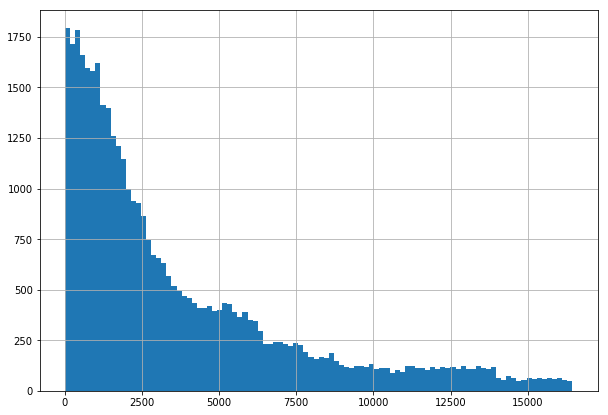

In [20]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

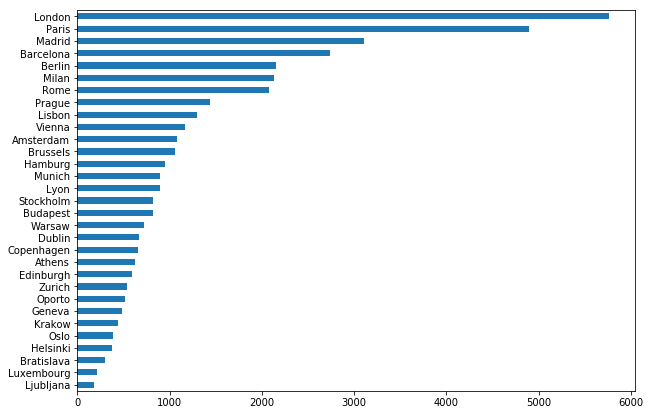

In [21]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

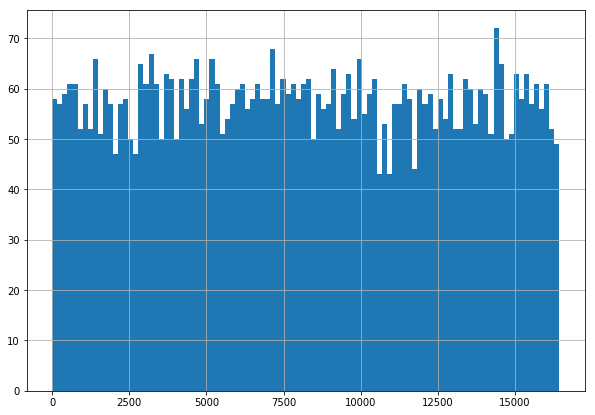

In [22]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

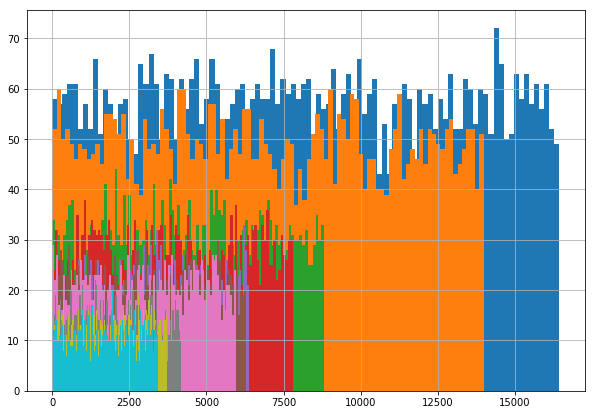

In [23]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

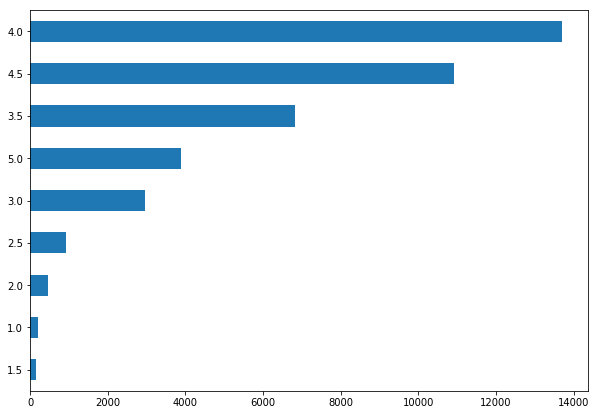

In [24]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

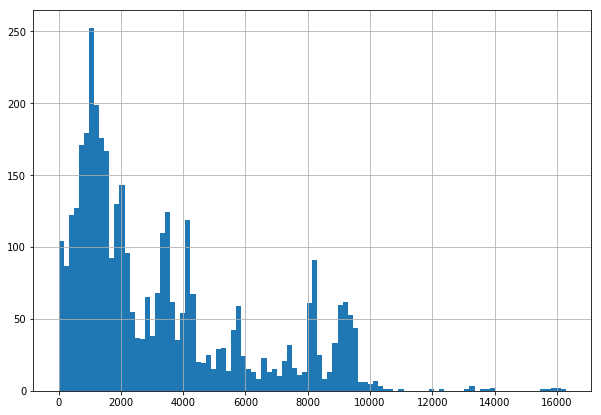

In [25]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

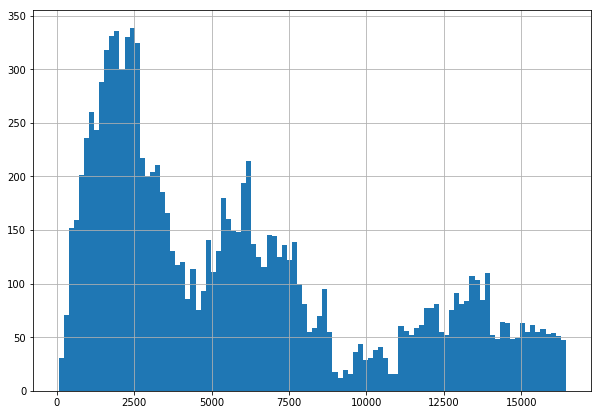

In [26]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

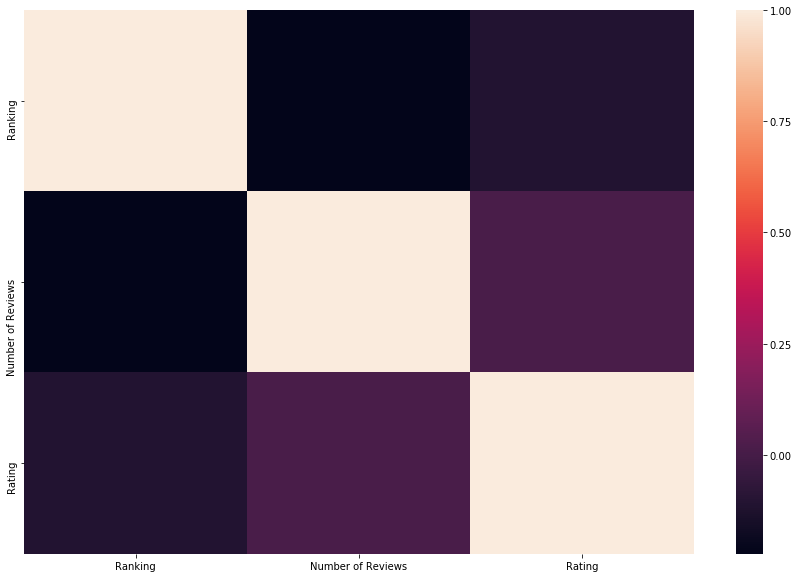

In [27]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [28]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [29]:
def preproc_data(df):
    '''includes several functions to pre-process the predictor data.'''
    

    # Приведем разброс цен к числовому значению, где 1 - самый низкий, 
    # а 3 - самый высокий

    def price(value):
        if value == '$':
            return 1
        elif value == '$$ - $$$':
            return 2
        elif value == '$$$$':
            return 3
        else: 
            return value

    price_range = df['Price Range'].apply(price)

    # Заменим здесь пропуски на моду
    price_range = price_range.fillna(price_range.mode()[0])


    # Добавим информацию о разнообразии меню (количестве кухонь)

    cuisine_count = list()
    cuisine_set = set()
    for cuisine_obj in df['Cuisine Style']:
        if type(cuisine_obj) != float:
            cuisine_list = cuisine_obj[2:-2].split("', '")
            cuisine_count.append(len(cuisine_list))
            for cuisine in cuisine_list:
                cuisine_set.add(cuisine)
        else:
            cuisine_count.append(1)

    cuisines = pd.Series(cuisine_count, name = 'Cuisine Counter')


    # Создадим Dummy-переменные для разных кухонь

    df['Cuisine Style'] = df['Cuisine Style'].dropna().apply(lambda x: x[2:-2].split("', '"))
    cuisine_frame = pd.DataFrame(0, index = range(len(df)), columns = cuisine_set)
    i = -1
    for line in df['Cuisine Style']:
        i += 1
        if type(line) != float:
            for cuisine in line:
                cuisine_frame[cuisine][i] = 1
        else: 
            continue

    # Создадим Dummy-переменные для городов

    cities = pd.get_dummies(df[['City']], dummy_na = True)

    # Создадим новый признак о разнице во времени между двумя последними отзывами

    review_delta = list()
    for review_obj in df['Reviews']:
        if (review_obj == '[[], []]') or type(review_obj) == float:
             review_delta.append(None)
        else:
            review = review_obj[2:-2].split("], [")
            review_list = [review[i][1:-1].split("', '") for i in range(2)]
            date_list = [datetime.strptime(review_list[1][i], '%m/%d/%Y') 
                         for i in range(len(review_list[1]))]
            review_delta.append(np.max(date_list) - np.min(date_list))

    review_delta = pd.Series(review_delta).apply(lambda x: x.days)

    # Избавимся от выбросов в timedelta отзывов

    def way_too_big_delta(delta):
        IQR = review_delta.quantile(0.75) - review_delta.quantile(0.25)
        upper_limit = review_delta.mean() + 1.5*IQR
        lower_limit = review_delta.mean() - 1.5*IQR
        if (delta > upper_limit) or (delta < lower_limit):
            return None
        else:
            return delta

    review_delta = review_delta.apply(way_too_big_delta)
    review_delta = review_delta.fillna(review_delta.mean())

    restaurant_id = df['Restaurant_id'].apply(lambda x: int(x[3:]))

    # Избавимся от колонок типа object
    columns_to_drop = []

    for column in df.columns:
        if df[column].dtype == 'O':
            columns_to_drop.append(column)

    df = df.drop(columns_to_drop, axis = 1)

    # Избавимся от пропусков
    df = df.fillna(0)
    
    # Получаем итоговый датасет:
    df_output = pd.concat([df, price_range, cuisines, cuisine_frame, 
                           cities, review_delta, restaurant_id], axis = 1)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [30]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,Price Range,Cuisine Counter,Romanian,Norwegian,Soups,Swedish,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,0,Restaurant_id
16052,684.0,22.0,1,4.0,2.0,2,0,0,0,0,...,0,0,0,0,0,1,0,0,70.761891,683
7718,170.0,44.0,0,0.0,1.0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,33.000000,7718
15372,550.0,16.0,1,4.5,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,35.000000,549
17789,696.0,126.0,1,4.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,285.000000,695
25192,331.0,425.0,1,4.5,2.0,7,0,0,0,0,...,1,0,0,0,0,0,0,0,8.000000,330
47372,5599.0,235.0,1,4.0,2.0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,14.000000,5590
13464,434.0,135.0,1,4.0,2.0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,9.000000,433
18411,733.0,114.0,1,4.5,2.0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,2.000000,732
39696,1872.0,15.0,1,4.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,70.761891,1869
18835,1602.0,25.0,1,4.5,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,33.000000,1600


In [31]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [32]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [33]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 164), (40000, 164), (40000, 163), (32000, 163), (8000, 163))

# Model 
Сам ML

In [34]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [35]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [36]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [37]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20977437499999999


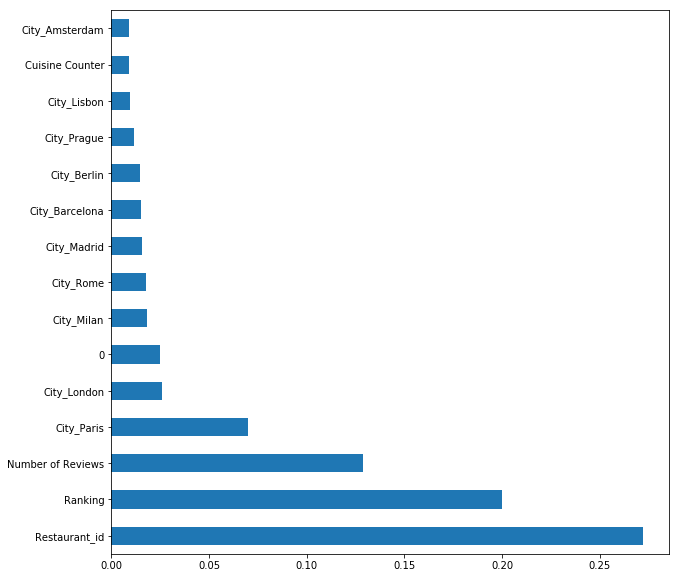

In [38]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [39]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Price Range,Cuisine Counter,Romanian,Norwegian,Soups,Swedish,Contemporary,...,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,0,Restaurant_id
6723,5266.0,217.0,0.0,2.0,6,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.000000,6723
6947,1711.0,73.0,0.0,2.0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,39.000000,6947
1404,1934.0,43.0,0.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,306.000000,1404
342,15557.0,32.0,0.0,2.0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,42.000000,342
5009,3853.0,120.0,0.0,2.0,3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,70.761891,5009
2077,835.0,68.0,0.0,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,107.000000,2077
2431,6066.0,11.0,0.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64.000000,2431
4952,40.0,4977.0,0.0,2.0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.000000,4952
535,2670.0,18.0,0.0,2.0,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,70.761891,535
3953,4275.0,136.0,0.0,2.0,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,27.000000,3953


In [40]:
test_data = test_data.drop(['Rating'], axis=1)

In [41]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [42]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [43]:
predict_submission

array([4.29 , 4.49 , 4.605, ..., 2.705, 3.3  , 4.125])

In [44]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,4.290
1,id_1,4.490
2,id_2,4.605
3,id_3,4.385
4,id_4,4.500
5,id_5,4.580
6,id_6,4.020
7,id_7,3.760
8,id_8,4.565
9,id_9,4.655


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
